In [41]:

import pandas as pd
import requests
import json
pd.set_option("display.max_columns", None)

import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

dict_pos = {'Lateral':'LAT',
            'Atacante':'ATA',
            'Meia':'MEI',
            'Goleiro':'GOL',
            'Zagueiro':'ZAG',
            'Técnico':'TEC'}


database = '/home/anderson/globo/gitlab/Ferramentas_Automatizadas_Gato_Mestre/database/2023/Cartola_2023'
dataCartola = pd.read_csv(database, compression='gzip')
dataCartola['clube'] = dataCartola['clube'].replace('Athletico-PR', 'Athlético-PR')

rodada_max = dataCartola.rodada_id.max()
rodada_max

# filtros
pontuou = (dataCartola['pontos_num'] != 0) | (dataCartola['variacao_num'] != 0)
jogou = (dataCartola['jogos_num'] > 0)

# colunas
columns = ['atleta_id', 'apelido','posicao', 'clube', 'jogos_num', 
           'preco_num', 'variacao_num', 'pontos_num', 'media_num', 'rodada_id']

atletasJogaram = dataCartola[jogou]
atletasNuncaJogaram = dataCartola[~jogou][~dataCartola['atleta_id'].isin(atletasJogaram['atleta_id'].unique())]

print('Atletas que jogaram: ', atletasJogaram.shape[0])
print('Atletas que nunca jogaram: ', atletasNuncaJogaram.shape[0])

dfAtletas = pd.DataFrame()
for atleta in atletasJogaram.atleta_id.unique():
    dfAtletas = dfAtletas.append(atletasJogaram[(atletasJogaram['atleta_id']==atleta) & pontuou].\
            sort_values('jogos_num', ascending=False).head(1)[columns], ignore_index = True)
    
for atleta in atletasNuncaJogaram.atleta_id.unique():
    dfAtletas = dfAtletas.append(atletasNuncaJogaram[(atletasNuncaJogaram['atleta_id']==atleta)].\
            sort_values('jogos_num', ascending=False).head(1)[columns], ignore_index = True)
    
    
dfAtletas.rename(columns={
    'preco_num': 'ultimo_preco',
    'variacao_num': 'ultima_variacao',
    'pontos_num': 'ultima_pontuacao',
    'media_num': 'ultima_media_pontos',
    'rodada_id': 'ultima_rodada_id'
}, inplace=True)
dfAtletas['pos_sigla'] = dfAtletas['posicao'].map(dict_pos)

Atletas que jogaram:  3670
Atletas que nunca jogaram:  1547


In [42]:

def medias_atleta(atleta_id, column):
    atleta = dataCartola[(dataCartola['atleta_id']==atleta_id)]
    ultima_rodada = atleta['rodada_id'].max()
    atleta = atleta[atleta['rodada_id']<ultima_rodada]
    medias = atleta[['preco_open', 'pontos_num', 'variacao_num']].mean()
    return round(medias[column], 2)

def medias_atleta_completa(atleta_id, column, rodada_atual):
    atleta = dataCartola[(dataCartola['atleta_id']==atleta_id)]
    ultima_rodada = atleta['rodada_id'].max()
    atleta = atleta[atleta['rodada_id']<ultima_rodada]
    soma = atleta[['preco_open', 'pontos_num', 'variacao_num']].sum()
    return round((soma[column]/(rodada_atual-1)), 2)


def medias_rodada(rodada_id, column):
    rodada = dataCartola[(dataCartola['rodada_id']==rodada_id)]
    rodada = rodada[(rodada['pontos_num'] != 0) & (rodada['variacao_num'] != 0)]
    medias = rodada[['preco_open', 'pontos_num', 'variacao_num']].mean()
    return round(medias[column], 2)

dfAtletas['preco_medio_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta(x, 'preco_open'))
dfAtletas['pontuacao_media_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta(x, 'pontos_num'))
dfAtletas['variacao_media_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta(x, 'variacao_num'))

dfAtletas['preco_medio_completo_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta_completa(x, 'preco_open', 13))
dfAtletas['pontuacao_media_completa_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta_completa(x, 'pontos_num', 13))
dfAtletas['variacao_media_completa_at'] = dfAtletas['atleta_id'].apply(lambda x: medias_atleta_completa(x, 'variacao_num', 13))

dfAtletas['preco_medio_rodada'] = dfAtletas['ultima_rodada_id'].apply(lambda x: medias_rodada(x, 'preco_open'))
dfAtletas['pontuacao_media_rodada'] = dfAtletas['ultima_rodada_id'].apply(lambda x: medias_rodada(x, 'pontos_num'))
dfAtletas['variacao_media_rodada'] = dfAtletas['ultima_rodada_id'].apply(lambda x: medias_rodada(x, 'variacao_num'))

dfAtletas['diff_preco_medio'] = dfAtletas['ultimo_preco'] - dfAtletas['preco_medio_at']
dfAtletas['diff_pontuacao_media'] = dfAtletas['ultima_pontuacao'] - dfAtletas['pontuacao_media_at']
dfAtletas['diff_variacao_media'] = dfAtletas['ultima_variacao'] - dfAtletas['variacao_media_at']

dfAtletas['diff_preco_medio_completo'] = dfAtletas['ultimo_preco'] - dfAtletas['preco_medio_completo_at']
dfAtletas['diff_pontuacao_media_completa'] = dfAtletas['ultima_pontuacao'] - dfAtletas['pontuacao_media_completa_at']
dfAtletas['diff_variacao_media_completa'] = dfAtletas['ultima_variacao'] - dfAtletas['variacao_media_completa_at']

dfAtletas['diff_preco_medio_geral'] = dfAtletas['ultimo_preco'] - dfAtletas['preco_medio_rodada']
dfAtletas['diff_pontuacao_media_geral'] = dfAtletas['ultima_pontuacao'] - dfAtletas['pontuacao_media_rodada']
dfAtletas['diff_variacao_media_geral'] = dfAtletas['ultima_variacao'] - dfAtletas['variacao_media_rodada']
dfAtletas.fillna(0, inplace=True)

dfAtletas_Pontuaram = dfAtletas[~((dfAtletas['ultima_pontuacao'] == 0) & (dfAtletas['jogos_num'] > 0))]
dfAtletas_nao_Pontuaram = dfAtletas[((dfAtletas['ultima_pontuacao'] == 0) & (dfAtletas['jogos_num'] > 0))]
dfAtletas_nunca_jogaram = dfAtletas[((dfAtletas['jogos_num'] == 0))]

rodada_max
rodada = rodada_max
rodada

8

In [43]:
def linearRegression(X, y):
    print ('Dataset shape: ',X.shape)
    
    ####### Treinando o regressor:
    reg_model = LinearRegression()
    reg_model.fit(X, y)
    print(reg_model)
    print(X.columns)
    print('coef_',reg_model.coef_)
    print('intercept_',reg_model.intercept_)

    # Extraindo a métrica R2 para treino:
    y_pred_test_model = reg_model.predict(X)
    r2_train = r2_score(y, y_pred_test_model)
    print(f'R2 treino: {r2_train : .6f}')
    
    print('R2:', r2_score(y, y_pred_test_model))
    print('MAE: ', mean_absolute_error(y, y_pred_test_model))
    print('MSE:', mean_squared_error(y, y_pred_test_model))
    print('-------------------------\n\n')

    plt.figure(figsize=(10,10))
    plt.scatter(y, y_pred_test_model, c='crimson')
    p1 = max(max(y_pred_test_model), max(y))
    p2 = min(min(y_pred_test_model), min(y))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    
    plt.figure(figsize=(10,10))
    sns.residplot(y, y_pred_test_model)
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show() 
    
    yhatFormula = y_pred_test_model
    
    return yhatFormula

In [44]:
def min_valorizar_final(X, rodada):
      val = 0
      if X['ultima_rodada_id'] == rodada:
            val = (  0.59026935   *  X['ultima_pontuacao'])    +\
                  (  -0.01730351  *  X['diff_pontuacao_media'])    +\
                  0.09689845205501157
      else:  
            if X['jogos_num'] > 1: 
                  
                  if X['ultima_pontuacao'] == 0:
                        val = (  1.4421092   *  X['diff_preco_medio_completo'])    +\
                              ( -1.40595357  *  X['ultima_variacao'])    +\
                              (  1.95448003  *  X['diff_variacao_media'])    +\
                              (  0.34281961  *  X['diff_pontuacao_media_geral'])    +\
                              1.3132283131074551
                  else:
                        val = (  -0.56443463  *  X['diff_preco_medio_completo'])    +\
                              (  -0.0856294   *  X['ultima_media_pontos'])    +\
                              (  0.53938066   *  X['ultima_pontuacao'])    +\
                              (  -0.2955632   *  X['ultima_variacao'])    +\
                              (  0.47467247   *  X['ultimo_preco'])    +\
                              -0.3027862786796067
            else:
                  val = ( -0.15417763  *  X['ultima_pontuacao'])    +\
                        ( 1.42  *  X['ultimo_preco'])    +\
                        -0.3027862
      return round(val,2)

In [45]:
dfAtletas['min_valorizar'] = np.nan
for index, x in dfAtletas.iterrows():
    val = min_valorizar_final(x, rodada)
    dfAtletas['min_valorizar'].iloc[index] = val

In [39]:
dfAtletasaval = dfAtletas[['atleta_id', 'apelido', 'clube', 'jogos_num', 'ultima_pontuacao',  'ultima_media_pontos', 'min_valorizar']]

In [13]:
dfAtletas['min_valorizar'][dfAtletas['atleta_id']==90031] = 11.8
dfAtletas['min_valorizar'][dfAtletas['atleta_id']==68952] = 2.0
dfAtletas['min_valorizar'][dfAtletas['atleta_id']==109591] = 8.0
dfAtletas['min_valorizar'][dfAtletas['atleta_id']==118774] = 8.6
dfAtletas['min_valorizar'][dfAtletas['atleta_id']==117870] = 1.4
dfAtletas['min_valorizar'][dfAtletas['atleta_id']==106829] = 4.6
dfAtletas['min_valorizar'][dfAtletas['atleta_id']==89273] = 1.2
dfAtletas['min_valorizar'][dfAtletas['atleta_id']==72595] = 4.9
dfAtletas['min_valorizar'][dfAtletas['atleta_id']==99412] = 4.7

In [18]:
ids_problema = [90031, 68952, 109591, 118774, 117870, 106829, 89273, 72595, 99412]
df_teste = dfAtletas[dfAtletas['atleta_id'].isin(ids_problema)]

In [55]:

def carrega_externo(rodada, make_request=False):
    if make_request:
        HOST = 'https://cartolaanalitico.com/api/scouts'
        USER_AGENT = 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Mobile Safari/537.36'
        PAYLOAD = {
        "pos": "",
        "weight_cartoletas": 0
        }
        headers = {'User-Agent': USER_AGENT}
        response = requests.post(url=HOST, data=PAYLOAD, headers=headers)
        response.json()
        with open(f"saved_2023_r{rodada}.json", 'w') as f:
            json.dump(response.json(), f)
    
    
    
    df = pd.read_json(f"saved_2023_r{rodada}.json")
    df = pd.DataFrame.from_dict(df['players'].to_dict(), orient='index')
    df = df.replace('-','0')
    df[['ca', 'dd', 'ds', 'fc', 'fn', 'fs', 'ga', 'ip', 'minval', 'pi',
        'pontos', 'preco', 'sg', 'valor']] = df[['ca', 'dd', 'ds', 'fc', 'fn', 'fs', 'ga', 'ip', 'minval', 'pi',
        'pontos', 'preco', 'sg', 'valor']].astype(float)
    return df

In [56]:
df_analitico = carrega_externo(rodada+1, make_request=True)
df_analitico.head()

,ca,dd,ds,fc,fn,fs,ga,ip,minval,nome,pi,pontos,pos,preco,sg,status,time,valor
0,10.0,0.0,0.5,0.4,1.9,2.0,68.0,0.1,6.2,Dudu,0.0,10.3,ATA,16.00,0.0,Provável,Palmeiras,0.9
1,11.0,0.0,0.8,0.8,1.7,1.5,66.0,0.3,5.5,Artur,0.0,9.9,ATA,12.07,0.0,Provável,Palmeiras,0.9
2,15.0,0.0,0.7,1.1,2.1,2.4,59.0,0.6,10.2,Luis Suárez,0.0,9.3,ATA,14.90,0.0,Provável,Grêmio,-0.2
3,16.0,0.0,0.1,1.0,2.1,2.5,55.0,0.5,1.4,Hulk,0.0,8.0,ATA,16.67,0.0,Provável,Atlético-MG,1.4
4,13.0,0.0,0.4,0.6,1.8,1.2,54.0,0.4,4.9,Gabriel,0.0,7.4,ATA,14.85,0.0,Provável,Flamengo,0.5


In [57]:
dfCompleto = df_analitico.merge(dfAtletas, how='left', left_on=['nome', 'pos', 'time'], right_on=['apelido', 'pos_sigla', 'clube'])
dfCompleto.reset_index(inplace=True)
dfCompleto['diff'] = dfCompleto['min_valorizar'] - dfCompleto['minval'] 
df_aval = dfCompleto.sort_values('diff')


# Aqui só se quiser alterar

In [29]:
###CASO 1: 

dfSelecionado = dfCompleto
dfSelecionado = dfSelecionado[dfSelecionado['ultima_rodada_id'] == rodada_max]
variables     = ['ultima_pontuacao',
                 'diff_pontuacao_media']

In [40]:
###CASO 2: 

dfSelecionado = dfCompleto
dfSelecionado = dfSelecionado[dfSelecionado['ultima_rodada_id'] < rodada_max]
dfSelecionado = dfSelecionado[dfSelecionado['jogos_num'] < 2]
variables     = ['ultima_pontuacao',
                 'ultimo_preco']

IndentationError: unexpected indent (<ipython-input-40-53a1661ca058>, line 7)

Dataset shape:  (3, 2)
LinearRegression()
Index(['ultima_pontuacao', 'ultimo_preco'], dtype='object')
coef_ [-0.15417763  1.425     ]
intercept_ -0.5250000000000004
R2 treino:  1.000000
R2: 1.0
MAE:  7.771561172376096e-16
MSE: 6.286235338479938e-31
-------------------------




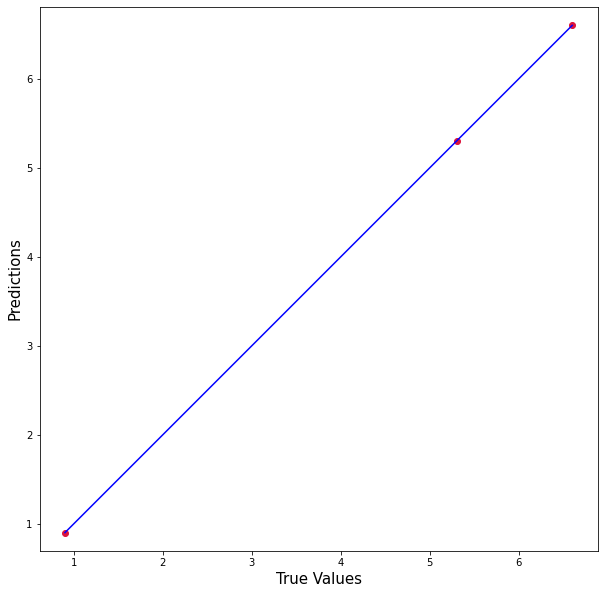

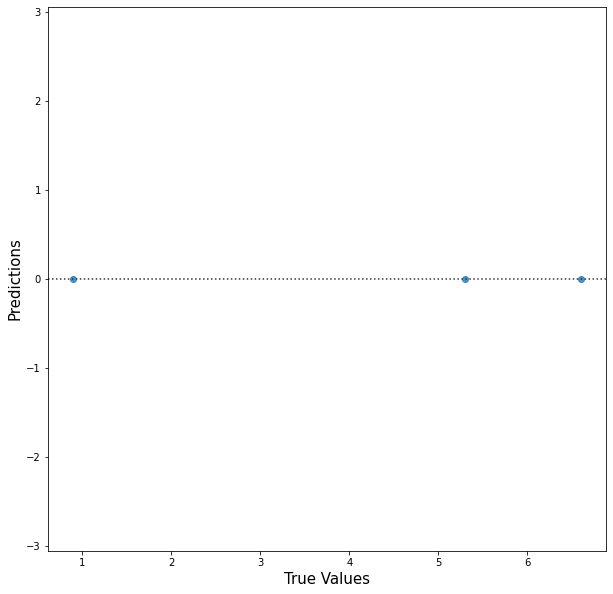

In [48]:
yHat = linearRegression(dfSelecionado[variables], dfSelecionado['minval'])

In [20]:
dfSelecionado = df_teste

In [31]:
dfSelecionado = dfSelecionado[dfSelecionado['jogos_num']>1]

In [32]:
dfSelecionado.corr()['min_valorizar'].sort_values(ascending=False)

min_valorizar                    1.000000
diff_preco_medio_completo        0.838437
ultima_variacao                  0.776870
diff_pontuacao_media_geral       0.762349
diff_variacao_media_completa     0.729239
diff_variacao_media              0.686494
ultimo_preco                     0.670436
ultima_media_pontos              0.653316
diff_variacao_media_geral        0.625445
diff_preco_medio                 0.617390
pontuacao_media_at               0.598603
pontuacao_media_completa_at      0.598545
preco_medio_completo_at          0.476593
preco_medio_at                   0.476149
atleta_id                        0.463550
jogos_num                        0.178147
variacao_media_completa_at      -0.058586
variacao_media_at               -0.061456
diff_preco_medio_geral          -0.094768
ultima_rodada_id                -0.352315
diff_pontuacao_media_completa   -0.598545
diff_pontuacao_media            -0.598603
preco_medio_rodada              -0.759118
variacao_media_rodada           -0

Dataset shape:  (7, 4)
LinearRegression()
Index(['diff_preco_medio_completo', 'ultima_variacao', 'diff_variacao_media',
       'diff_pontuacao_media_geral'],
      dtype='object')
coef_ [ 1.4421092  -1.40595357  1.95448003  0.34281961]
intercept_ 1.3132283131074551
R2 treino:  0.994697
R2: 0.9946973795125429
MAE:  0.19677710659391237
MSE: 0.06584123177507416
-------------------------




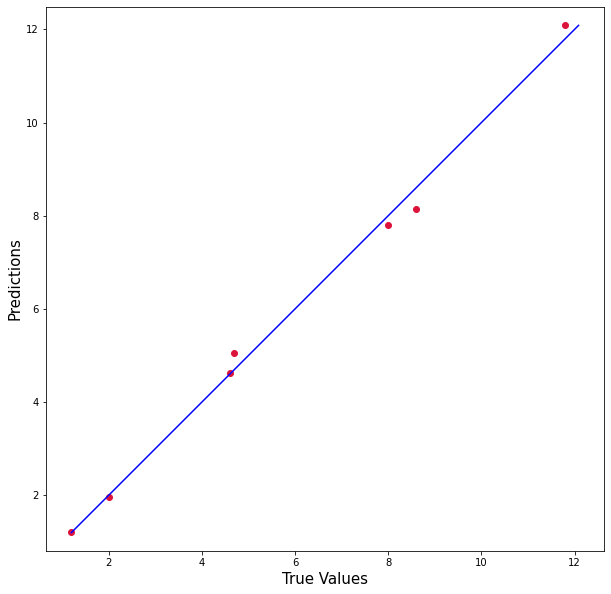

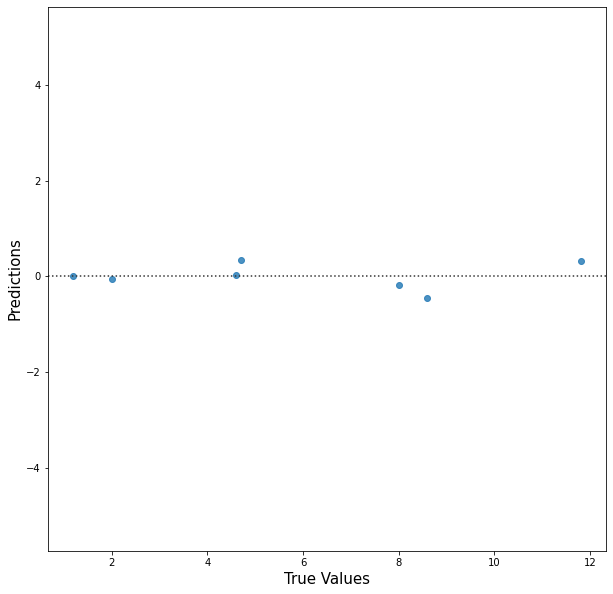

In [36]:
variables = [
            'diff_preco_medio_completo',
            #'diff_preco_medio',
            #'ultima_media_pontos',
            #'ultima_pontuacao',
            #'diff_pontuacao_media',
            'ultima_variacao',
            'diff_variacao_media',
            #'ultimo_preco',
            #'diff_preco_medio',
            #'diff_preco_medio_geral',
            'diff_pontuacao_media_geral',
            #'diff_preco_medio_geral',
            #'ultimo_preco',
            #'diff_pontuacao_media_completa',
            #'diff_pontuacao_media',
            #'diff_preco_medio',
            #'ultima_variacao',
            #'diff_variacao_media',
            #'preco_medio_rodada'    
            #'ultimo_preco',
            #'diff_preco_medio',
            #'diff_variacao_media',
            #'diff_preco_medio',
            #'ultima_media_pontos',
            #'ultimo_preco',
            #'variacao_media_at'
            #'diff_pontuacao_media'
            #'preco_anterior',
            #'media_num_anterior',
            #'pontuacao_anterior',
            #'variacao_anterior',
            #'ultimo_preco',
            #'diff_pontuacao_media',
            #'pontuacao_media_at',
            ##'ultima_media_pontos',
            ##'ultima_pontuacao',
            #'ultima_variacao',
            #'valor', 
            #'variacao_num',
            #'ultimo_preco', 
            ]

yHat = linearRegression(dfSelecionado[variables], dfSelecionado['min_valorizar'])

In [322]:
dfSelecionado['min_valorizar'] = yHat

In [323]:
dfSelecionado['diff'] = dfSelecionado['min_valorizar'] - dfSelecionado['minval']

In [324]:
dfSelecionado.sort_values('diff')

,index,ca,dd,ds,fc,fn,fs,ga,ip,minval,nome,pi,pontos,pos,preco,sg,status,time,valor,atleta_id,apelido,posicao,clube,jogos_num,ultimo_preco,ultima_variacao,ultima_pontuacao,ultima_media_pontos,ultima_rodada_id,pos_sigla,preco_medio_at,pontuacao_media_at,variacao_media_at,preco_medio_completo_at,pontuacao_media_completa_at,variacao_media_completa_at,preco_medio_rodada,pontuacao_media_rodada,variacao_media_rodada,diff_preco_medio,diff_pontuacao_media,diff_variacao_media,diff_preco_medio_completo,diff_pontuacao_media_completa,diff_variacao_media_completa,diff_preco_medio_geral,diff_pontuacao_media_geral,diff_variacao_media_geral,min_valorizar,diff
73,73,15.0,0.0,0.7,1.0,1.1,2.1,29.0,0.2,8.7,Soteldo,0.0,4.5,ATA,9.26,0.0,Provável,Santos,-0.9,87258,Soteldo,Atacante,Santos,2,9.26,-0.03,7.7,5.05,3,ATA,9.73,1.68,-0.46,4.86,0.84,-0.23,6.85,3.63,0.09,-0.47,6.02,0.43,4.40,6.86,0.20,2.41,4.07,-0.12,8.7,-9.592327e-14
16,16,15.0,0.0,1.9,1.0,0.4,0.9,18.0,0.1,6.5,Varela,0.0,5.7,LAT,5.00,42.0,Dúvida,Flamengo,-0.2,84816,Varela,Lateral,Flamengo,0,5.00,0.00,0.0,0.00,1,LAT,5.00,0.00,0.00,2.50,0.00,0.00,6.56,3.79,0.12,0.00,0.00,0.00,2.50,0.00,0.00,-1.56,-3.79,-0.12,6.5,1.421085e-14
203,203,13.0,0.0,0.6,0.5,0.3,0.4,9.0,0.1,3.8,Nathan Silva,0.0,2.9,ZAG,5.25,31.0,Provável,Atlético-MG,-0.2,95794,Nathan Silva,Zagueiro,Atlético-MG,2,5.25,0.45,5.8,5.65,6,ZAG,4.97,0.97,0.04,2.48,0.48,0.02,6.73,4.00,0.06,0.28,4.83,0.41,2.77,5.32,0.43,-1.48,1.80,0.39,3.8,3.996803e-14
61,61,14.0,0.0,1.7,0.9,0.4,0.5,16.0,0.1,4.9,Fernando,0.0,4.7,LAT,4.48,35.0,Provável,Athlético-PR,-0.0,106950,Fernando,Lateral,Athlético-PR,2,4.48,1.26,8.5,6.60,6,LAT,3.04,1.42,0.25,1.52,0.71,0.12,6.73,4.00,0.06,1.44,7.08,1.01,2.96,7.79,1.14,-2.25,4.50,1.20,4.9,9.059420e-14


# Aqui preparando para entregar

In [46]:
df_min_valorizar = dfAtletas.copy()
df_avaliacao = df_min_valorizar[['jogos_num', 'atleta_id', 'apelido', 'clube', 'min_valorizar']]

dict_json = {"assinante": True,
             "rodada": rodada+1,
             "atletas": df_min_valorizar[['atleta_id', 'min_valorizar']].set_index('atleta_id').to_dict()['min_valorizar']
             }

df = pd.DataFrame.from_dict(dict_json, orient='index')
df[0].to_json(path_or_buf=f'2023/minimor{rodada+1}.json')
